In [2]:
from QIP import *

In [3]:
def grovers(goal_state, num_iterations):
    num_qubits = len(goal_state)+1
    circuit = QCircuit(num_qubits)
    
    # h on all except ancilla
    for qubit in range(num_qubits-1):
        circuit.h(qubit)
    # NOT on ancilla    
    circuit.x(num_qubits-1)
    # grover iteration
    for grover_iteration in range(num_iterations):
        # phase flip ancilla controlled by bitstring of goal state
        circuit.apply_to_circuit(arbitrary_U(x,num_qubits,[num_qubits-1],control_bitstring=goal_state))
        
        # h on all except ancilla
        for qubit in range(num_qubits-1):
            circuit.h(qubit)

        # phase flip ancilla if state is all zeros
        circuit.apply_to_circuit(arbitrary_U(z,num_qubits,[num_qubits-1],control_bitstring='0'*len(goal_state)))

        # h on all except ancilla
        for qubit in range(num_qubits-1):
            circuit.h(qubit)
    return circuit

In [6]:
grovers_circuit = grovers('11010',int(2**2.5))

KeyboardInterrupt: 

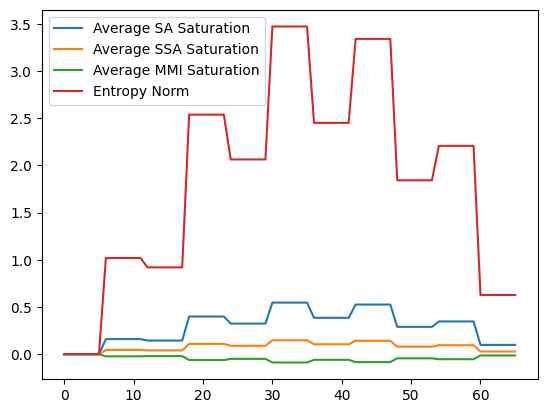

In [5]:
grovers_circuit.plot_saturations()

In [10]:
def qft(circuit_size):
        
    circuit = QCircuit(circuit_size)
    
    # Begin the QFT
    for i in range(circuit_size):
        circuit.h(i)
        
        for k in range(2,circuit_size-i+1):
            R_k = np.array([[1.,0.],[0.,np.exp(1.j*2*np.pi/2**k)]])
            circuit.apply_to_circuit(arbitrary_U(R_k,circuit_size,[i],controls=[i+k-1]))
    circuit.reverse_bits()
    return circuit

In [8]:
qft_circuit = qft(3)

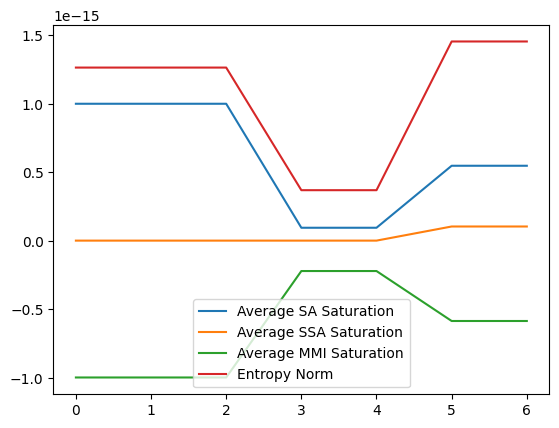

In [20]:
qft_circuit.plot_saturations()

In [4]:
def qft_inverse(circuit_size):
        
    circuit = QCircuit(circuit_size)
    
    # Begin the QFT
    
    # Hadamard on every qubit
    for i in range(circuit_size):
        circuit.h(i)
        
        # Controlled reverse-phase on each qubit 
        for k in range(2,circuit_size-i+1):
            R_k = np.array([[1.,0.],[0.,np.exp(-1.j*2*np.pi/2**k)]])
            circuit.apply_to_circuit(arbitrary_U(R_k,circuit_size,[i],controls=[i+k-1]))
    circuit.reverse_bits()
    return circuit

In [10]:
qft_i_circuit = qft_inverse(3)

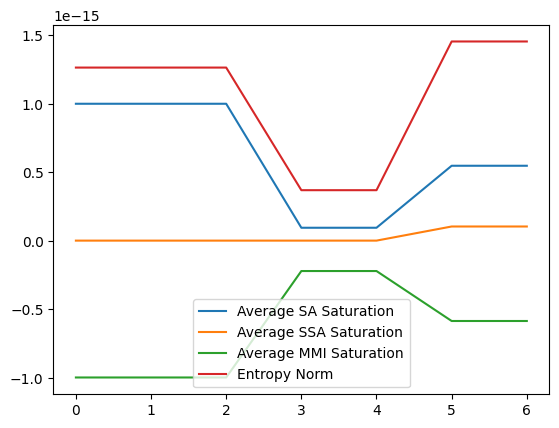

In [19]:
qft_i_circuit.plot_saturations()

In [16]:
def qpe(U,num_auxiliary_bits,eigvec):
    
    m = int(np.log2(np.shape(U)[0]))
    num_qubits = num_auxiliary_bits + m
    circuit = QCircuit(num_qubits,initial_state=np.kron(bitstrings_to_vector('0'*num_auxiliary_bits),eigvec))
    for i in range(num_auxiliary_bits):
        circuit.h(i)
    for k in range(num_auxiliary_bits):
        circuit.apply_to_circuit(arbitrary_U(U**(2**k),num_qubits,list(range(num_auxiliary_bits,num_qubits)),controls=[num_qubits-m-1-k]))
    qfti_circuit = qft_inverse(num_auxiliary_bits)
    #qfti_circuit.reverse_bits()
    circuit.apply_to_circuit(arbitrary_U(qfti_circuit.unitary,num_qubits,list(range(num_auxiliary_bits))))
    return circuit

In [19]:
l = np.random.random()
test_gate = np.array([[1.,0.],[0.,np.exp(np.pi*1.j*l)]])
eigval = np.linalg.eig(test_gate)[0][1]
eigvec = np.linalg.eig(test_gate)[1][:,1]
theta=np.log(eigval)/(2*np.pi*1.j)
print("theta = ",end="")
print(np.round(theta,5))
print("eigenvector:",end="")
print(np.round(eigvec,5))

qpe_circuit = qpe(test_gate,3,eigvec)

theta = (0.32052+0j)
eigenvector:[0.+0.j 1.+0.j]


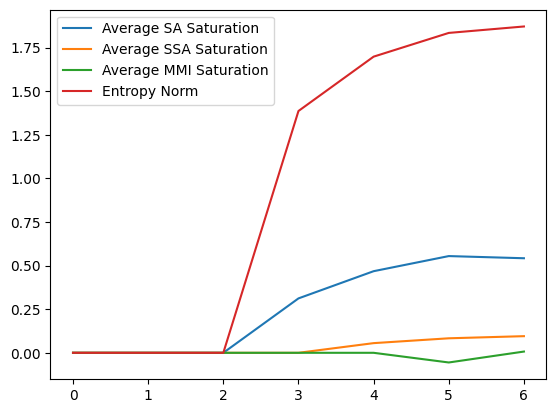

In [25]:
qpe_circuit.plot_saturations()

In [9]:
#Here we build the unitary needed for Shor's. In each step of phase estimation we must construct a new one
def order_finding_U(a,n,N):
    U = np.zeros((2**n,2**n))
    for k in range(2**n):
        if k < N: 
            transformed_k = (a*k)%N
        else: transformed_k = k
        row = np.array(1.)
        for bit in int_to_bitstring(transformed_k,n):
            row = np.kron(row,qubit_map[bit])
        U[k]=row
    return U.T

def order_finding(a,N):
    
    # number of qubits in second register
    n = int(np.ceil(np.log2(N)))
    
    # accuracy and number of qubits in first register
    m = 2*n+1
    
    # now execute the circuit
    circuit = QCircuit(m+n)
    
    # phase estimation step 
    
    # second register starts as |1>
    for q in range(m,n+m):
        circuit.x(q)
    
    # hadamard on all inputs
    for q in range(m):
        circuit.h(q)
    
    # controlled unitaries
    for k in range(m):
        circuit.apply_to_circuit(arbitrary_U(order_finding_U(a**(2**k),n,N),n+m,list(range(m,n+m)),controls=[n-1-k]))
    
    # inverse qft
    qfti_circuit = qft_inverse(m)
    circuit.apply_to_circuit(arbitrary_U(qfti_circuit.unitary,n+m,list(range(m))))
    return circuit
    
    
    

    

In [13]:
shors = order_finding(3,5)

KeyboardInterrupt: 

(array([127.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

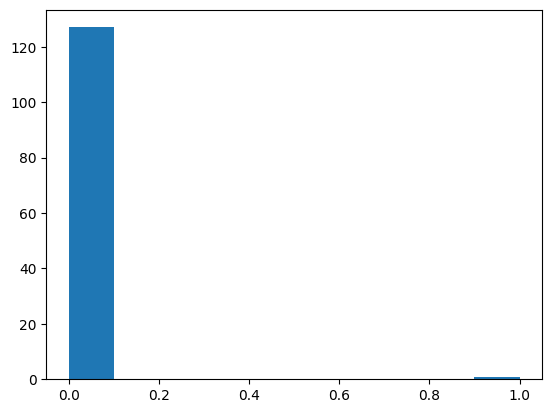

In [11]:
import matplotlib.pyplot as plt
plt.hist([np.abs(s)**2 for s in shors.statevector])

In [20]:
a=8
N=15

n = int(np.ceil(np.log2(N)))
m = 2*n+1
U = np.zeros((2**n,2**n))
for k in range(2**n):
    if k < N: 
        transformed_k = (a*k)%N
    else: transformed_k = k
    row = np.array(1.)
    for bit in int_to_bitstring(transformed_k,n):
        row = np.kron(row,qubit_map[bit])
    U[k]=row
U=U.T
checkOperator(U,form='int')

0 -> 0
1 -> 8
2 -> 1
3 -> 9
4 -> 2
5 -> 10
6 -> 3
7 -> 11
8 -> 4
9 -> 12
10 -> 5
11 -> 13
12 -> 6
13 -> 14
14 -> 7
15 -> 15


In [14]:
for k in range(16):
    print(str(k)+ " -> " + str((a*k)%N))

0 -> 0
1 -> 8
2 -> 1
3 -> 9
4 -> 2
5 -> 10
6 -> 3
7 -> 11
8 -> 4
9 -> 12
10 -> 5
11 -> 13
12 -> 6
13 -> 14
14 -> 7
15 -> 0


In [6]:
test = QCircuit(3)
for q in range(2):
    test.h(q)
state_as_string(test.statevector)

'0.5|000> + 0.5|010> + 0.5|100> + 0.5|110>'

In [7]:
test.measure([0,2])

{'00': 0.4999999999999998, '10': 0.4999999999999998}


In [15]:
class testing:
    def __init__(self,age,initial_test=None):
        if initial_test == None:
            self.age=age
        else: self.__dict__.update(initial_test.__dict__)

dylan = testing(26)
josh=testing(12,initial_test=dylan)
josh.age
    

26

Notationally the partial trace is written as $\text{tr}_A$ if one is 'tracing out' the $A$ subsystem, or indices, of a larger system. Thus $\text{tr}_A(\rho)$ is the reduced density matrix representing the state of the $B$ subystem. 
$$
\text{tr}_A(\rho_{AB})\equiv \rho_B = \sum_j(I_A\otimes\bra{j}_B)\rho_{AB}(I_A\otimes\ket{j}_B)
$$
Note that when using this function one must pass the subystem to be traced out, not the subsystem to be kept.

In [1]:
def partial_trace(p,trace_out):
    """finds the reduced density matrix after tracing out the given indices

    Args:
        p (numpy.ndarray (2-d)): full density matrix
        trace_out (list): indices to trace out
    """
    d_b = len(trace_out)
    d_a = int(np.log2(np.shape(p)[0])) - d_b
    sum = 0
    for j in range(2**d_b):
        vec = np.zeros(2**d_b)
        vec[j]=1.
        vec.shape=(2**d_b,1)
        sum = sum + np.kron(np.eye(2**d_a),vec.conj().T)@p@np.kron(np.eye(2**d_a),vec)
    return sum


In [40]:
matrix = np.random.random((4,4))
partial_trace(matrix,[1])

array([[1.70266423, 0.31414284],
       [0.48052602, 1.62964366]])

In [42]:
partial_trace(matrix,[0])

DensityMatrix([[1.70266423+0.j, 0.31414284+0.j],
               [0.48052602+0.j, 1.62964366+0.j]],
              dims=(2,))


In [3]:
list(range(5)).remove(list(range(3)))

AttributeError: 'list' object has no attribute 'removeall'

In [5]:
import numpy as np
all_qubits = list(range(3))
np.delete(all_qubits,list(range(2)))


array([2])

In [1]:
import numpy as np
from itertools import chain, combinations
def bipartitioning(qubs):
    """
    Generate a list of all bipartitions of a list

    Parameters:
    qubs (list): list to find all bipartitions of
    
    Returns: 
    bipartitions (list): list of all bipartitions where each element has 2 lists, the list of elements in the first piece, and the remining list of its complement
    """

    #Number of elements in the overall system
    N=len(qubs)
    bipartitions = list()

    #Loop over number of elements in the first subsystem from 0 to N/2
    for size_A in range(int(np.floor(N/2))+1):
        #Generates a tuple of all combinations that can be made of size_A qubits out of the system
        combs = combinations(qubs,size_A)
        #Loop over every possible combination
        for c in combs:
            combination = list(c)
            #Determine the complement of the combination that completes the system
            complement = qubs[:]
            for bit in combination:
                complement.remove(bit)
            if size_A == int(N/2):
                if [complement, combination] in bipartitions: break
            #Each bipartition has 2 subsystems, the list of pieces in the first subsystem, and its complement
            bipartitions.append([combination,complement])
        
    return bipartitions

def tripartitioning(qubs):
    """
    Generate a list of all tripartitions of a list

    Parameters:
    qubs (list): list to find all tripartitions of
    
    Returns: 
    tripartitions (list): list of all bipartitions where each element has 3 lists, the list of elements in the first piece, and the remining list of its complements
    """
    tripartitions = list()
    #Bipartition a single piece of each bipartition to form a tripartition
    for bipartition in bipartitioning(qubs):
        for piece in range(2):
            for subpartition in bipartitioning(bipartition[piece]):
                new_tripartition = [subpartition[0],subpartition[1],bipartition[1-piece]]
                new_tripartition.sort()
                if new_tripartition not in tripartitions:
                    tripartitions.append(new_tripartition)
    tripartitions.sort()
    return tripartitions

In [3]:
a=np.random.random((2,2))
b=np.random.random((2,2))
np.kron(a,b)

array([[0.22362172, 0.63323957, 0.09247725, 0.26187194],
       [0.01496178, 0.64366732, 0.00618734, 0.26618426],
       [0.26686984, 0.75570722, 0.15630272, 0.44260936],
       [0.01785537, 0.76815167, 0.01045769, 0.44989794]])

In [4]:
np.kron(b,a)

array([[0.22362172, 0.09247725, 0.63323957, 0.26187194],
       [0.26686984, 0.15630272, 0.75570722, 0.44260936],
       [0.01496178, 0.00618734, 0.64366732, 0.26618426],
       [0.01785537, 0.01045769, 0.76815167, 0.44989794]])

In [48]:
def n_partitioning(qubs, n):
    """
    Generate a list of all n-partitions of a list.

    Parameters:
    lst (list): List to find all n-partitions of
    n (int): Number of subsets in each partition

    Returns:
    partitions (list): List of all partitions where each partition is a list of n subsets
    """
    N=len(qubs)
    partitions = []
    if n==1: return list(range(N))
    
    if n==2: 
        #Loop over number of elements in the first subsystem from 0 to N/2
        for size_A in range(1,int(np.floor(N/2))+1):
            #Generates a tuple of all combinations that can be made of size_A qubits out of the system
            combs = combinations(qubs,size_A)
            #Loop over every possible combination
            for c in combs:
                combination = list(c)
                #Determine the complement of the combination that completes the system
                complement = qubs[:]
                for bit in combination:
                    complement.remove(bit)
                if size_A == int(N/2):
                    if [complement, combination] in partitions: break
                #Each bipartition has 2 subsystems, the list of pieces in the first subsystem, and its complement
                partitions.append([combination,complement])
        return partitions
    
    else:
        for partition in n_partitioning(qubs,n-1):
            for piece in range(n-1):
                for subpartition in n_partitioning(partition[piece],2):
                    new_partition=partition[:piece]+[sub for sub in subpartition] + partition[piece+1:]
                    new_partition.sort()
                    if new_partition not in partitions:
                        partitions.append(new_partition)
    return partitions

In [101]:
def set_partitions2(iterable, k=None):
    """
    Yield the set partitions of *iterable* into *k* parts. Set partitions are
    not order-preserving.

    >>> iterable = 'abc'
    >>> for part in set_partitions(iterable, 2):
    ...     print([''.join(p) for p in part])
    ['a', 'bc']
    ['ab', 'c']
    ['b', 'ac']


    If *k* is not given, every set partition is generated.

    >>> iterable = 'abc'
    >>> for part in set_partitions(iterable):
    ...     print([''.join(p) for p in part])
    ['abc']
    ['a', 'bc']
    ['ab', 'c']
    ['b', 'ac']
    ['a', 'b', 'c']

    """
    L = list(iterable)
    n = len(L)
    if k is not None:
        if k == 0: 
            return iter(())
        if k < 0:
            raise ValueError(
                "Can't partition in a negative number of groups"
            )
        elif k > n:
            return

    def set_partitions_helper(L, k):
        n = len(L)
        if k == 0: 
            yield iter(())
        if k == 1:
            yield [L]
        elif n == k:
            yield [[s] for s in L]
        else:
            e, *M = L
            for p in set_partitions_helper(M, k - 1):
                yield [[e], *p]
            for p in set_partitions_helper(M, k):
                for i in range(len(p)):
                    yield p[:i] + [[e] + p[i]] + p[i + 1 :]

    if k is None:
        for k in range(1, n + 1):
            yield from set_partitions_helper(L, k)
    else:
        yield from set_partitions_helper(L, k)

In [102]:
e, *M = [0,1,2,3,4]
M

[1, 2, 3, 4]

In [ ]:
np.

In [103]:
list(set_partitions2(list(range(4)),3))

[[[0], [1], [2, 3]],
 [[0], [1, 2], [3]],
 [[0], [2], [1, 3]],
 [[0, 1], [2], [3]],
 [[1], [0, 2], [3]],
 [[1], [2], [0, 3]]]

In [72]:
import time
s=time.time()
n_partitioning(list(range(4)),3)
e=time.time()
d=e-s
print(e-s)

0.00019860267639160156


In [73]:
s=time.time()
list(set_partitions2(list(range(4)),3))
e=time.time()
d2=e-s
print(e-s)
print(d/d2)

7.772445678710938e-05
2.5552147239263805


In [ ]:
def subsysem_analysis(self):
    """calculates subadditivity, strong subadditivity, and monogamy of mutual information inequality saturations as well as the complete entropy vector and the entropies for individual qubits and populates the associated lists  
    """
    norm = 0
    entropies_map = dict()
    entropy_vector = []
    subsystems = list(chain.from_iterable(bipartitioning(list(range(self.circuit_size)))))
    subsystems.sort(key=len)
    subsystems.pop(0)
    subsystems.sort()
    sum_sa = 0
    num_sa_checks = 0
    sum_ssa = 0
    num_ssa_checks = 0
    sum_mmi = 0
    
    
    for subsystem in n_partitioning(self.all_qubits,2):
        # originally we stored all reduced density matrices first labeled by the qubits which were not traced out for later use in inequality checks
        # actually we really need the entropies, so thats what we calculate and store here
        reduced_dm = partial_trace(self.density_matrix,subsystem[0])
        probs = np.linalg.eigvals(np.array(reduced_dm.data)).tolist()
        entropy = shannon_ent([p_i.real for p_i in probs])
        # S_A always = S_B if S_AB = 0 (S_AB is pure) so we dont waste time calculating it again
        entropies_map[tuple(subsystem[0])] = entropy
        entropies_map[tuple(subsystem[1])] = entropy
        entropy_vector.append(entropy)
    
    
    
    # Now for all our entropy inequality checks
    for subsystem in self.subsystems:
        this_subsystem_entropy = entropies_map[tuple(subsystem)]
        
        # for all biparitions check subadditivity
        for subsystem_bipartition in n_partitioning(subsystem,2):
            sa_saturation = entropies_map[tuple(subsystem_bipartition[0])] + entropies_map[tuple(subsystem_bipartition[1])] - this_subsystem_entropy
            num_sa_checks = num_sa_checks + 1
            sum_sa = sum_sa + sa_saturation
            if sa_saturation < -1e-10:
                print("subadditivity failed for subsystem bipartitioned as ",end="")
                print(subsystem_bipartition)
                print("Saturation: "+str(sa_saturation))
                
        # for all tripartitions check strong subadditivity and monogamy of mutual information    
        for subsystem_tripartition in n_partitioning(subsystem,3):
            e_12 = entropies_map[tuple(sorted(subsystem_tripartition[0]+subsystem_tripartition[1]))]
            e_23 = entropies_map[tuple(sorted(subsystem_tripartition[1]+subsystem_tripartition[2]))]
            e_2  = entropies_map[tuple(subsystem_tripartition[1])]
            
            ssa_saturation = e_12+e_23-e_2-this_subsystem_entropy
            
            sum_ssa = sum_ssa + ssa_saturation
            num_ssa_checks = num_ssa_checks + 1
            if ssa_saturation < -1e-10:
                print("strong subadditivity failed for ",end="")
                print(subsystem_tripartition)
                print("Saturation: "+str(ssa_saturation))
                
                
            e_13 = entropies_map[tuple(sorted(subsystem_tripartition[0]+subsystem_tripartition[2]))]
            e_1 = entropies_map[tuple(subsystem_tripartition[0])]
            e_3 = entropies_map[tuple(subsystem_tripartition[2])]
            mmi_saturation = e_12+e_13+e_23-e_1-e_2-e_3-this_subsystem_entropy
            sum_mmi = sum_mmi + mmi_saturation
            
        # for all quadpartitions? check ingleton's inequality
        
        self.entropies.append(entropy_vector)
        self.norms.append(np.sqrt(norm)/2**.5)
        self.avg_sas.append(sum_sa/num_sa_checks)
        self.avg_ssas.append(sum_ssa/num_ssa_checks)
        self.avg_mmis.append(sum_mmi/num_ssa_checks)
        for i in range(len(subsystems)):
            if len(subsystems[i]) == 1:
                self.single_qubit_entropy_series[subsystems[i][0]].append(entropy[i])
    
    

In [55]:
a=[0,1]
b=[3,5]
a+b

[0, 1, 3, 5]

In [21]:
circuit_size=5
subsystems = list(chain.from_iterable(bipartitioning(list(range(circuit_size)))))
a=tuple(subsystems[0])
dict[a]=9
dict[()]

TypeError: 'type' object does not support item assignment